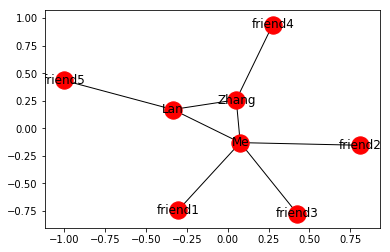

In [2]:
import networkx as nx
import gensim 
import numpy as np
import matplotlib.pyplot as plt
node_list=['friend1','friend2','friend3','Me','Zhang','Lan','friend4','friend5']
edge_list=[('friend1','Me',1),('friend2','Me',1),('friend3','Me',1),('Zhang','Me',5.20)
,('Lan','Me',2.50),('friend4','Zhang',1),('friend5','Lan',1),('Zhang','Lan',2.50)]
#创建空图
G=nx.Graph()
#从一个列表中添加节点
G.add_nodes_from(node_list)
#根据（边，边，权重）加载
G.add_weighted_edges_from(edge_list)
#plot
nx.draw_networkx(G,node_list=G.nodes(),edges=G.edges())

In [20]:
G.edges(data=True)
G.has_edge('friend1','Me')


True

In [15]:
class AliasSampling:
    def __init__(self,area_ratio):
        self.area_ratio=area_ratio
        self.accept,self.alias=self.create_alias_table()
        self.alias_sample()
    def create_alias_table(self):
        N=len(self.area_ratio)
        accept,alias=[0]*N,[0]*N
        small,large=[],[]
        area_ratio=np.array(self.area_ratio)*N
        for i,prob in enumerate(area_ratio):
            if prob<1:
                small.append(i)
            else:
                large.append(i)
        while large and small:
            small_idx,large_idx=small.pop(),large.pop()
            accept[small_idx]=area_ratio[small_idx]
            alias[small_idx]=large_idx
            area_ratio[large_idx]=area_ratio[large_idx]-(1-alias[small_idx])
            if area_ratio[large_idx]<1:
                small.append(large_idx)
            else:
                large.append(large_idx)
            
        while large:
            large_idx=large.pop()
            accept[large_idx]=1
        while small:
            small_idx=small.pop()
            accept[small_idx]=1
        return accept,alias
    
    def alias_sample(self):
        N=len(self.accept)
        i=int(np.floor(np.random.rand()*N))
        r=np.random.rand()
        if r<self.accept[i]:
            return i
        else:
            return self.alias[i]
        

In [83]:
class DataLoader:
    def __init__(self,G):
        self.g=G
        self.num_of_nodes=self.g.number_of_nodes()
        self.num_of_edges=self.g.number_of_edges()
        self.edges_raw=list(self.g.edges(data=True))
        self.nodes_raw=list(self.g.nodes())
        self.edge_distribution=np.array([attr['weight'] for _,_,attr in self.edges_raw],dtype=np.float32)
        self.edge_distribution/=np.sum(self.edge_distribution)
        self.node_negative_distribution=np.power(np.array([self.g.degree(node) for node in self.nodes_raw],dtype=np.float32),0.75)
        self.node_negative_distribution/=np.sum(self.node_negative_distribution)
        #创建节点表
        self.node2idx={}
        self.idx2node={}
        for idx,node in enumerate(self.nodes_raw):
            self.node2idx[node]=idx
            self.idx2node[idx]=node
        self.edges=[(self.node2idx[u],self.node2idx[v]) for u,v,_ in self.edges_raw]
        
    def fetch_batch(self,batch_size=5,K=3):
        edge_batch_idx=np.random.choice(self.num_of_edges,size=batch_size,p=self.edge_distribution)
        print(edge_batch_idx)
        u_i=[]
        u_j=[]
        label=[]
        for edge_idx in edge_batch_idx:
            edge=self.edges[edge_idx]
            #这里是无向图，但之前的边的列表里(u,v)和(v,u)只存了一条
            if np.random.rand()>0.5:
                edge=(edge[1],edge[0])
            u_i.append(edge[0])
            u_j.append(edge[1])
            label.append(1)
            #进入负采样
            for i in range(K):
                while True:
                    negative_node=np.random.choice(self.num_of_nodes,p=self.node_negative_distribution)
                    #若采样到不相连的即富采样成功退出while true循环，接着负采样。
                    if not self.g.has_edge(self.idx2node[edge[0]],self.idx2node[negative_node]):
                        break
                u_i.append(edge[0])
                u_j.append(negative_node)
                label.append(-1)
        return u_i,u_j,label
        
    def embedding_mapping(self,embedding):
        return {node:embedding[self.node2idx[node]] for node in self.nodes_raw}
            
        

In [84]:
import tensorflow as tf

class LINE:
    def __init__(self,args):
        self.u_i=tf.placeholder(dtype=tf.int32,shape=[args.batch_size*(args.K+1)],name='u_i')
        self.u_j=tf.placeholder(dtype=tf.int32,shape=[args.batch_size*(args.K+1)],name='u_j')
        self.label=tf.placeholder(dtype=tf.float32,shape=[args.batch_size*(args.K+1)],name='label')
        with tf.variable_scope('embedding',reuse=tf.AUTO_REUSE):
            self.embedding=tf.Variable(tf.truncated_normal([args.num_of_nodes,args.embedding_dim]))
        #self.embedding=tf.get_variable(shape=[args.num_of_nodes,args.embedding_dim],initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
         #                              name='embedding')
        self.u_i_embedding=tf.nn.embedding_lookup(self.embedding,self.u_i)
        if args.proximity=='first-order':
            self.u_j_embedding=tf.nn.embedding_lookup(self.embedding,self.u_j)
        elif args.proximity=='second-order':
            with tf.variable_scope('context_embedding',reuse=tf.AUTO_REUSE):
                self.context_embedding=tf.Variable(tf.truncated_normal([args.num_of_nodes,args.embedding_dim]))
            #self.context_embedding=tf.get_variable(shape=[args.num_of_nodes,args.embedding_dim],initializer=tf.random_uniform_initializer(minval=-1., maxval=1.),
              #                                    name='context_embedding')
            self.u_j_embedding=tf.nn.embedding_lookup(self.context_embedding,self.u_j)
        self.inner_product=tf.reduce_sum(self.u_i_embedding*self.u_j_embedding,axis=1)
        self.loss=-tf.reduce_mean(tf.log_sigmoid(self.label*self.inner_product))
        self.learning_rate=tf.placeholder(dtype=tf.float32,name='learning_rate')
        self.optimizer=tf.train.RMSPropOptimizer(learning_rate=self.learning_rate)
        self.train_op=self.optimizer.minimize(self.loss)
        
            

In [91]:
from argparse import Namespace

        
def train(args):
    data_loader=DataLoader(G)
    suffix=args.proximity
    args.num_of_nodes=data_loader.num_of_nodes
    model=LINE(args)
    with tf.Session() as sess:
        tf.global_variables_initializer().run()
        initial_embedding=sess.run(model.embedding)
        learning_rate=args.learning_rate
        u_i,u_j,label=data_loader.fetch_batch(batch_size=args.batch_size,K=args.K)
        print(len(u_i))
        for i in range(args.num_batches):
            #u_i,u_j,label=data_loader.fetch_batch(batch_size=args.batch_size,K=args.K)
            feed_dict={model.u_i:u_i,model.u_j:u_j,model.label:label,model.learning_rate:learning_rate}
            loss,_=sess.run([model.loss,model.train_op],feed_dict=feed_dict)
            print(i,loss)
        if i==args.num_batches-1:
            embedding=sess.run(model.embedding)
            normalized_embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
            return data_loader.embedding_mapping(normalized_embedding)
if __name__=='__main__':
    args=Namespace()
    args.proximity='second-order'
    args.embedding_dim=20
    args.num_batches=100
    args.K=3
    args.batch_size=5
    args.learning_rate=0.001
    embedding_dict=train(args)
            
        



[3 6 3 3 4]
20
0 1.8365726
1 1.8356022
2 1.8345814
3 1.8335078
4 1.832379
5 1.8311924
6 1.8299458
7 1.8286355
8 1.8272597
9 1.8258148
10 1.8242981
11 1.8227069
12 1.821038
13 1.8192883
14 1.8174543
15 1.8155334
16 1.8135217
17 1.8114169
18 1.809215
19 1.8069134
20 1.8045084
21 1.8019974
22 1.7993772
23 1.7966449
24 1.7937975
25 1.7908322
26 1.7877461
27 1.7845373
28 1.781203
29 1.7777412
30 1.7741499
31 1.7704268
32 1.766571
33 1.7625806
34 1.7584553
35 1.754193
36 1.7497936
37 1.7452571
38 1.7405834
39 1.7357724
40 1.7308247
41 1.7257411
42 1.7205231
43 1.7151715
44 1.7096878
45 1.7040746
46 1.6983337
47 1.6924675
48 1.6864786
49 1.6803696
50 1.6741436
51 1.667804
52 1.6613537
53 1.6547966
54 1.6481361
55 1.6413758
56 1.6345192
57 1.6275705
58 1.6205332
59 1.6134115
60 1.6062092
61 1.5989301
62 1.591578
63 1.5841569
64 1.5766704
65 1.5691222
66 1.5615162
67 1.5538558
68 1.5461447
69 1.538386
70 1.530583
71 1.5227392
72 1.5148574
73 1.5069406
74 1.4989917
75 1.4910133
76 1.4830083
77 1

In [106]:
def cos_similarity(a,b):
    a=np.mat(a)
    b=np.mat(b)
    num = float(a * b.T)
    denom = np.linalg.norm(a) * np.linalg.norm(b)
    cos = num / denom
    sim = 0.5 + 0.5 * cos
    return sim
    

In [109]:
embedding_dict['Me']
cos_similarity(embedding_dict['Zhang'],embedding_dict['Lan'])

0.4472441939857122